# Business Challange

## Planning IoT 

### Input

    - Challenge
        - Deploy de uma API que disponibiliza um endpoit GET que recebe como parâmetro na URL o número da conta e retorna o valor 0 para conta que o modelo considere lícita e 1 caso o modelo considere ilícita. A rota deve seguir a seguinte estrutura: URL/?account_number=12345
        
    - Sqlite database tables
        1. Accounts
        2. Address
        3. Levels
        4. Charges
        5. Transactions
        6. transaction_type

### Output

    1. Exploratory Data Analysis
    2. Classification model (0 licit account | 1 ilicit account)
    3. API that receive the account number and return the classification

### Tasks

    1. Conectar ao banco e desenvolver as querys para obter os dados
   
    2. Realizar análise descritiva dos dados utilizando linguagem R ou Python. Os resultados e códigos desta análise devem ficar salvos em um arquivo gerado via Rmarkdown ou Jupyter Notebook
    
    3. Desenvolver um modelo, linguagem R ou Python, para classificar as contas em lícitas ou ilícitas utilizando as estratégias e métricas que julgar relevantes dado o escopo do problema.
    
    4. Disponibilizar a classificação obtida pelo modelo das contas presentes no banco que não possuem classificação na tabela levels, escolhendo estre as seguintes opções: 
    
        Opção 1: Deploy de uma API que disponibiliza um endpoit GET que recebe como parâmetro na URL o número da conta e retorna o valor 0 para conta que o modelo considere lícita e 1 caso o modelo considere ilícita. A rota deve seguir a seguinte estrutura: URL/?account_number=12345
        
        Opção 2: Gerar um csv com as colunas account_number e fraud. Sendo que a coluna fraud deve ter os seguintes valores: 0 para contas lícitas e 1 para ilícitas
        
     
     
<font size=5>**CRISP-DS**</font>

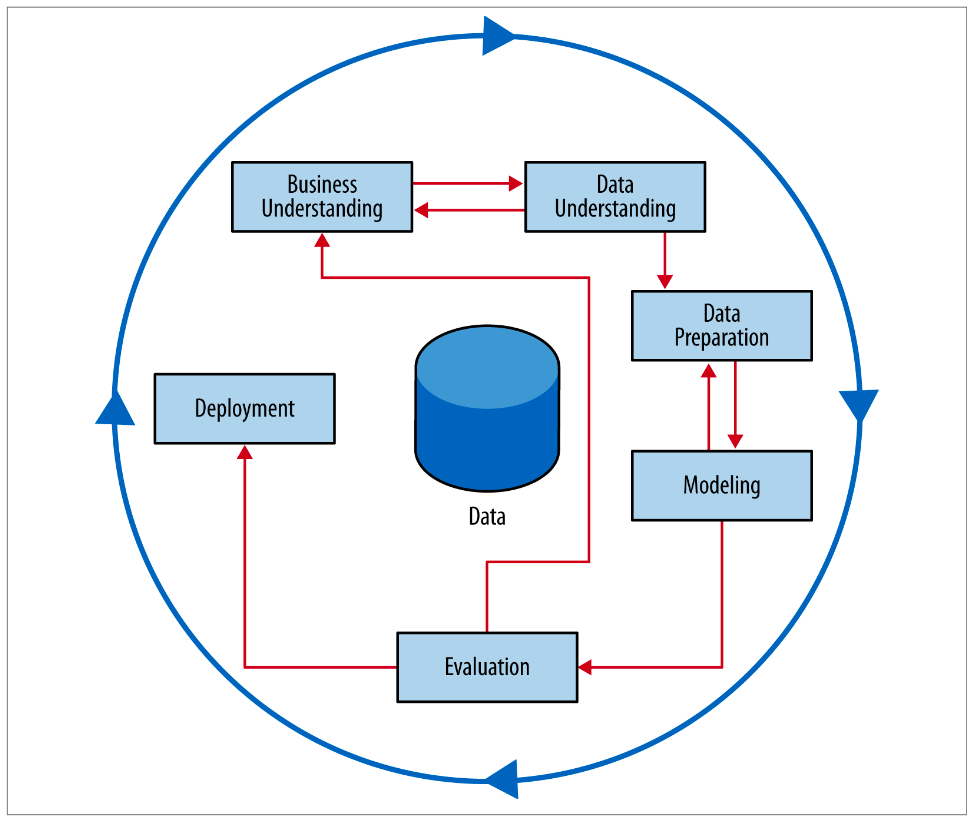

# Dev Enviroment

## Imports

In [75]:
#==========================Data Manipulation=====================
import numpy  as np
import pandas as pd
import pickle
import random
from   datetime import datetime
#==========================Visualization=========================
import seaborn           as sns
import matplotlib.pyplot as plt

from tabulate        import tabulate
from IPython.display import HTML
from IPython.display import Image

#==========================Sqlite================================
import sqlite3
from   sqlalchemy import create_engine

#==========================Model=================================
## Preprocessing
from sklearn.preprocessing   import LabelEncoder
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.preprocessing   import RobustScaler
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split

## Estimator
from boruta                  import BorutaPy
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedKFold

## Metics
from sklearn.metrics         import balanced_accuracy_score
from sklearn.metrics         import cohen_kappa_score
from scikitplot.metrics      import plot_confusion_matrix

#==========================Data Manipulation=====================
import os
import requests
from flask import Flask, request, Response

## Fuctions

### SQL

In [2]:
def database_conn(database=str):
    '''
    --> Create a database connection
    
    :param str database: Database to connect
    
    return database connection
    '''
    db = create_engine(f'sqlite:///../data/{database}', echo=False)
    return db.connect()

### Data Analysis

In [3]:
def frequency_table(data):
    display(pd.DataFrame({'%': round(data.value_counts(normalize=True) * 100)}))

In [4]:
def graph_info_num(fig=None, title=str, xlabel=str, ylabel=str, x_rotation=0):
    '''
    --> Settings and information for a graph with numerical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    fig.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
    fig.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

In [46]:
def graph_info_cat(title=str, xlabel='', ylabel='', x_rotation=0):
    '''
    --> Settings and information for a graph with categorical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### Models

In [2]:
def model_performance(model=None, X_train=None, y_train=None, X_val=None, y_val=None, ordinal_encoder=None):
    '''
    --> Make the train and validate the model performance with Balanced Accuracy, Kappa Score and Confusion Matrix
    
    :param model: Machine Learning Model to be evaluated
    :param X_train: Train data to fit model
    :param y_train: Train target to fit model
    :param X_val: Data validation to predict target
    :param y_val: Target data to evaluate the model
    :param ordinal_encoder: Encoder to reverse target information
    '''
    # Model Definition
    ml = model.fit(X_train, y_train)
    
    # Predict
    pred = ml.predict(X_val)
    
    # Inverse Order Encoder
    yhat = ordinal_encoder.inverse_transform(pred.reshape(-1, 1))
    
    # Model Performance
    ## Balanced Accuracy
    bcs = round(balanced_accuracy_score(y_val, yhat), 2)
    print(f'Balanced Accuracy: {bcs}')
    
    ## Kappa Metrics
    cks = round(cohen_kappa_score(y_val, yhat), 2)
    print(f'Kappa Score: {cks}')
    
    ## Confusion Matrix
    plot_confusion_matrix(y_val, yhat, normalize=False, figsize=(12,12))
    plt.show()

In [3]:
def model_performance_cv(model=None, num_folds=5, X_train=None, y_train=None, verbose_sintetic=False):
    '''
    --> Show the model performance with cross-validation
    
    :param model: Machine Learning Model to be evaluated
    :num_folds: The number for stratified kfold
    :param X_train: Train data to fit model
    :param y_train: Train target to fit model
    :param verbose: Show the cross-validation results
    
    return Balanced Accuracy Mean, Balanced Accuracy Standard Deviation, Kappa Score Mean, Kappa Score Deviation
    '''
    # Generate k-fold
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7)
    count_k = 0
    bcs_list = list()
    cks_list = list()
    
    for train_ix, val_ix in kfold.split(X_train, y_train):
        count_k += 1
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]
        
        x_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        # Model training
        model.fit(X_train_fold, y_train_fold.values.ravel())
        
        # Predict
        yhat = model.predict(x_val_fold)
        
        # Model Performance
        ## Balanced Accuray
        bcs = round(balanced_accuracy_score(y_val_fold.values.ravel(), yhat), 2)
        bcs_list.append(bcs)
        
        ## Kappa Metrics
        cks = round(cohen_kappa_score(y_val_fold.values.ravel(), yhat), 2)
        cks_list.append(cks)
        
        if not verbose_sintetic:
            print(f'Kfold: {count_k}')
            print(f'Balanced Accuracy: {bcs}')
            print(f'Kappa Score: {cks}')
            print('')
        
    bcs_mean = round(np.mean(bcs_list), 2)
    bsc_std  = round(np.std(bcs_list), 2)
    cks_mean = round(np.mean(cks_list), 2)
    cks_std  = round(np.std(cks_list), 2)
    
    if verbose_sintetic:
        print(f'Balanced Accuracy: {bcs_mean} ± {bsc_std}')
        print(f'Kappa Score: {cks_mean} ± {cks_std}')
        print('')
    else:
        print('Results')
        print(f'Balanced Accuracy: {bcs_mean} ± {bsc_std}')
        print(f'Kappa Score: {cks_mean} ± {cks_std}')
        print('')

## Settings

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
display( HTML( '<style>.container { width:100% !important; }</style>') )
sns.set_style(style='darkgrid')

## Data Raw

Data query

    Account: 
        account_number (PK)
        address_id (FK)
        birth
        occupation
        email
        created_at as account_date
    
    Address:
        id (PK)
        state
        city 
        created_at as address_date
    
    Charges
        account number (PK)
        status
        value
        created_at as charge_date
        
    Levels
        account number (PK)
        level
        created_at as level_date
        
    Transactions:
        accont number (PK)
        transaction_type_id (FK)
        value
        created_at as transaction_date
        
    Transactions type
        id (PK)
        description
        description_long 

### Total charge

In [58]:
charge = '''
/* total_charges*/
with charges_paid as (
    select 
        c.account_number,
        sum(c.value) as paid,
        count(c.status) as num_paid
    from 
        charges c
    where 
        c.status = 'paid'
    group by
        c.account_number
), charges_unpaid as (
    select 
        c.account_number,
        sum(c.value) as unpaid,
        count(c.status) as num_unpaid
    from 
        charges c
    where 
        c.status = 'unpaid'
    group by
        c.account_number
), total_charges as (
    select 
        cp.account_number, 
        cp.paid, 
        cp.num_paid,
        cu.unpaid,
        cu.num_unpaid
    from 
        charges_paid as cp inner join charges_unpaid as cu on (cp.account_number = cu.account_number)
)

select * from total_charges;
'''
conn = database_conn('desafio-tecnico.db')
df_charges = pd.read_sql(charge, conn)

In [59]:
df_charges.head()

,account_number,paid,num_paid,unpaid,num_unpaid
0,2711,1252888,144,680523,75
1,2763,757596,128,558383,95
2,2957,285373,32,266485,30
3,3478,63315,18,61458,18
4,5561,230204,26,351879,40


### Total Transactions

In [60]:
transactions = '''
/* total_transactions*/
with total_transactions as (
select 
    t.account_number,
    t.transaction_type_id,
    sum(t.value) as total_transaction,
    count(t.transaction_type_id) as num_transaction
from 
    transactions t 
group by
    t.account_number,
    t.transaction_type_id
), total_transactions_type as (
select 
    tt.account_number,
    tt.total_transaction,
    tt.num_transaction, 
    ty.description
from total_transactions tt left join transaction_type ty on (tt.transaction_type_id = ty.id)
)

select * from total_transactions_type;
'''
df_transactions = pd.read_sql(transactions, conn)

In [61]:
df_transactions.head()

,account_number,total_transaction,num_transaction,description
0,2711,1252888,144,boleto_recebido
1,2711,2728475,9,pix_enviado
2,2711,1694047,193,pix_recebido
3,2763,757596,128,boleto_recebido
4,2763,1474822,11,pix_enviado


In [62]:
boleto_recebido = df_transactions[df_transactions['description'] == 'boleto_recebido'][['account_number', 'total_transaction', 
                                                                                       'num_transaction']].rename(columns={
                                                        'total_transaction': 'total_boleto', 'num_transaction': 'num_boleto'})

pix_enviado = df_transactions[df_transactions['description'] == 'pix_enviado'][['account_number', 'total_transaction',
                                                                               'num_transaction']].rename(columns={
                                                                                    'total_transaction': 'total_pix_enviado', 
                                                                                    'num_transaction': 'num_pix_enviado'})

pix_recebido = df_transactions[df_transactions['description'] == 'pix_recebido'][['account_number', 'total_transaction',
                                                                                 'num_transaction']].rename(columns={
                                                                                    'total_transaction': 'total_pix_recebido', 
                                                                                    'num_transaction': 'num_pix_recebido'})

In [63]:
operations = pd.merge(boleto_recebido, pix_enviado, on='account_number', how='left')
operations = pd.merge(operations, pix_recebido, on='account_number', how='left')

In [64]:
operations.head()

,account_number,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido
0,2711,1252888,144,2728475.0,9.0,1694047,193
1,2763,757596,128,1474822.0,11.0,1017267,171
2,2957,285373,32,778703.0,18.0,538767,60
3,3478,63315,18,177007.0,8.0,130192,37
4,5561,230204,26,648960.0,18.0,439900,49


### Account

In [65]:
account = '''
select 
    ac.account_number,
    ac.birth,
    ac.occupation,
    ac.created_at as account_date,
    ad.state,
    ad.city,
    ad.created_at as address_date,
    l."level" 
from accounts ac left join address ad on (ac.address_id = ad.id)
    left join levels l on (ac.account_number = l.account_number);
'''
df_account = pd.read_sql(account, conn)

In [66]:
df_account.head()

,account_number,birth,occupation,account_date,state,city,address_date,level
0,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,Carmo,2021-04-01 02:30:00,F
1,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,Bertopolis,2021-04-01 02:00:00,D
2,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,None
3,66402,1982-06-30,Investidor,2021-04-01 14:30:00,PR,Icaraima,2021-04-01 14:30:00,D
4,277012,1967-01-11,Outros,2021-04-02 15:30:00,ES,Ecoporanga,2021-04-02 15:30:00,D


### Data Merge

In [67]:
data_raw = pd.DataFrame()
data_raw = pd.merge(df_account, operations, on='account_number', how='left')
data_raw = pd.merge(data_raw, df_charges, on='account_number', how='left')

In [68]:
data_raw.head()

,account_number,birth,occupation,account_date,state,city,address_date,level,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido,paid,num_paid,unpaid,num_unpaid
0,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,Carmo,2021-04-01 02:30:00,F,342450.0,30.0,1016692.0,15.0,754686.0,66.0,342450.0,30.0,431396.0,39.0
1,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,Bertopolis,2021-04-01 02:00:00,D,375256.0,113.0,625227.0,10.0,566775.0,172.0,375256.0,113.0,512667.0,153.0
2,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,None,349747.0,64.0,1175602.0,8.0,860634.0,156.0,349747.0,64.0,426241.0,79.0
3,66402,1982-06-30,Investidor,2021-04-01 14:30:00,PR,Icaraima,2021-04-01 14:30:00,D,1341064.0,184.0,1321193.0,5.0,1221423.0,166.0,1341064.0,184.0,247459.0,33.0
4,277012,1967-01-11,Outros,2021-04-02 15:30:00,ES,Ecoporanga,2021-04-02 15:30:00,D,455390.0,90.0,1153644.0,9.0,796732.0,159.0,455390.0,90.0,569580.0,112.0


### Data Dictionary

In [173]:
tab = [
    ['Column',              'Description'],
    ['account_number',      'Número da conta'],
    ['birth',               'Data de nascimento'],
    ['occupation',          'Tipo de negócio autodeclarado'],
    ['account_date',        'Data de criação da conta'],
    ['state',               'Estado de residência do cliente'],
    ['city',                'Cidade de residência do cliente'],
    ['address_date',        'The date of address registration'],
    ['level',               'A, B, C, D e F'],
    ['total_boleto',        'Total amount (R$) of boletos'],
    ['num_boleto',          'The number of boletos'],
    ['total_pix_enviado',   'The amount (R$) of pix enviado'],
    ['num_pix_enviado',     'The number of pix enviado'],
    ['total_pix_recebido',  'The amount (R$) of pix recebido'],
    ['num_pix_recebido',    'The number of pix recebido'],
    ['paid',                'The amount (R$) of charges paid'],
    ['num_paid',            'The number of charges paid'],
    ['unpaid',              'The amount (R$) of charges unpaid'],
    ['num_unpaid',          'The number of charges unpaid']
]

print(tabulate(tab, tablefmt="fancy_grid"))

╒════════════════════╤═══════════════════════════════════╕
│ Column             │ Description                       │
├────────────────────┼───────────────────────────────────┤
│ account_number     │ Número da conta                   │
├────────────────────┼───────────────────────────────────┤
│ birth              │ Data de nascimento                │
├────────────────────┼───────────────────────────────────┤
│ occupation         │ Tipo de negócio autodeclarado     │
├────────────────────┼───────────────────────────────────┤
│ account_date       │ Data de criação da conta          │
├────────────────────┼───────────────────────────────────┤
│ state              │ Estado de residência do cliente   │
├────────────────────┼───────────────────────────────────┤
│ city               │ Cidade de residência do cliente   │
├────────────────────┼───────────────────────────────────┤
│ address_date       │ The date of address registration  │
├────────────────────┼──────────────────────────────────

### Data Output

In [69]:
data_raw.to_csv('../data/data_raw.csv', index=False)

# Description

## Data Input

In [87]:
df1 = pd.read_csv('../data/raw/data_raw.csv')
df1.head()

,account_number,birth,occupation,account_date,state,city,address_date,level,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido,paid,num_paid,unpaid,num_unpaid
0,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,Carmo,2021-04-01 02:30:00,F,342450.0,30.0,1016692.0,15.0,754686.0,66.0,342450.0,30.0,431396.0,39.0
1,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,Bertopolis,2021-04-01 02:00:00,D,375256.0,113.0,625227.0,10.0,566775.0,172.0,375256.0,113.0,512667.0,153.0
2,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,NaN,349747.0,64.0,1175602.0,8.0,860634.0,156.0,349747.0,64.0,426241.0,79.0
3,66402,1982-06-30,Investidor,2021-04-01 14:30:00,PR,Icaraima,2021-04-01 14:30:00,D,1341064.0,184.0,1321193.0,5.0,1221423.0,166.0,1341064.0,184.0,247459.0,33.0
4,277012,1967-01-11,Outros,2021-04-02 15:30:00,ES,Ecoporanga,2021-04-02 15:30:00,D,455390.0,90.0,1153644.0,9.0,796732.0,159.0,455390.0,90.0,569580.0,112.0


## Dimensions

In [71]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1029
Number of columns: 18


## Data Types

In [72]:
df1.dtypes

account_number          int64
birth                  object
occupation             object
account_date           object
state                  object
city                   object
address_date           object
level                  object
total_boleto          float64
num_boleto            float64
total_pix_enviado     float64
num_pix_enviado       float64
total_pix_recebido    float64
num_pix_recebido      float64
paid                  float64
num_paid              float64
unpaid                float64
num_unpaid            float64
dtype: object

In [ ]:
# birth               to date               
# account_date        to date
# address_date        to date
#total_boleto         divide by 100
#num_boleto           to int
#total_pix_enviado    divide by 100
#num_pix_enviado      to int
#total_pix_recebido   divide by 100
#num_pix_recebido     to int
#paid                 divide by 100
#num_paid             to int
#unpaid               divide by 100
#num_unpaid           to int

## Check NaN

In [73]:
df1.isna().sum()

account_number          0
birth                   0
occupation              0
account_date            0
state                   0
city                    0
address_date            0
level                 103
total_boleto          150
num_boleto            150
total_pix_enviado     165
num_pix_enviado       165
total_pix_recebido    150
num_pix_recebido      150
paid                  153
num_paid              153
unpaid                153
num_unpaid            153
dtype: int64

## Fill NaN

### Level

In [75]:
# Data to classification the level column
df1[pd.isna(df1['level'])].head()

,account_number,birth,occupation,account_date,state,city,address_date,level,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido,paid,num_paid,unpaid,num_unpaid
2,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,NaN,3497.47,64.0,11756.02,8.0,8606.34,156.0,3497.47,64.0,4262.41,79.0
6,108762,1982-10-15,Analista,2021-04-02 12:30:00,ES,Cachoeiro de Itapemirim,2021-04-02 12:30:00,NaN,8461.48,167.0,11492.30,13.0,3564.95,70.0,8461.48,167.0,2144.95,42.0
7,309054,1990-01-07,Desenvolvedor,2021-04-02 15:00:00,RJ,Mesquita,2021-04-02 15:00:00,NaN,12992.86,350.0,38475.66,54.0,26919.36,724.0,12992.86,350.0,14257.14,385.0
8,89836,1981-07-04,Investidor,2021-04-02 15:30:00,PR,Marechal Candido Rondon,2021-04-02 15:30:00,NaN,26013.81,482.0,79773.09,45.0,55448.19,1021.0,26013.81,482.0,10203.35,190.0
51,900180,1980-05-24,Corretor,2021-04-08 02:30:00,MG,Claudio,2021-04-08 02:30:00,NaN,6003.13,128.0,11114.83,11.0,6623.41,141.0,6003.13,128.0,3512.22,75.0


### total_boleto

In [88]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['total_boleto'].fillna(0, inplace=True)

### num_boleto

In [89]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['num_boleto'].fillna(0, inplace=True)

### total_pix_enviado

In [90]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['total_pix_enviado'].fillna(0, inplace=True)

### num_pix_enviado

In [91]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['num_pix_enviado'].fillna(0, inplace=True)

### total_pix_recebido

In [92]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['total_pix_recebido'].fillna(0, inplace=True)

### num_pix_recebido

In [93]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['num_pix_recebido'].fillna(0, inplace=True)

### paid

In [94]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['paid'].fillna(0, inplace=True)

### num_paid

In [95]:
df1['num_paid'].fillna(0, inplace=True)

### unpaid

In [96]:
# Fill with 0
# NaN implies that there was no such operation on the account
df1['unpaid'].fillna(0, inplace=True)

### num_unpaid

In [97]:
df1['num_unpaid'].fillna(0, inplace=True)

## Change Data Types

In [98]:
# Date time columns
df1['birth']        = pd.to_datetime(df1['birth'])
df1['account_date'] = pd.to_datetime(df1['account_date'])
df1['address_date'] = pd.to_datetime(df1['address_date'])

# Cents for real
df1['total_boleto']       = df1['total_boleto'] / 100
df1['total_pix_enviado']  = df1['total_pix_enviado'] / 100
df1['total_pix_recebido'] = df1['total_pix_recebido'] / 100
df1['paid']               = df1['paid'] / 100
df1['unpaid']             = df1['unpaid'] / 100

# Float to int
df1['num_boleto']       = df1['num_boleto'].astype('int64')
df1['num_pix_enviado']  = df1['num_pix_enviado'].astype('int64')
df1['num_pix_recebido'] = df1['num_boleto'].astype('int64')
df1['num_paid']         = df1['num_paid'].astype('int64')
df1['num_unpaid']       = df1['num_unpaid'].astype('int64')

## Descriptive Statistics

### Numerical

In [102]:
num_attributes = df1.select_dtypes(include=['int64', 'float64']).copy()

# Columns to analyze
num_attributes = num_attributes[['total_boleto', 'num_boleto', 'total_pix_enviado', 'num_pix_enviado', 'total_pix_recebido',
                               'num_pix_recebido', 'paid', 'num_paid', 'unpaid', 'num_unpaid']].copy()

# General Stats
num_stats = num_attributes.describe().T

# Range
_range = pd.Series(num_attributes.max() - num_attributes.min(), name='range')

# Skew
skew = pd.Series(num_attributes.skew(), name='skew')

# Kurtosis

kurtosis = pd.Series(num_attributes.kurtosis(), name='kurtosis')

# Result 

num_stats = pd.concat([num_stats, _range, skew, kurtosis], axis=1)

# Reorder columns to analyze
num_stats = num_stats[['count', 'min', 'max', 'range', 'mean', '50%', '25%', '75%', 'std', 'skew', 'kurtosis']].rename(columns={
  '50%': 'median', '25%': 'Q1', '75%': 'Q3'})

In [103]:
num_stats

,count,min,max,range,mean,median,Q1,Q3,std,skew,kurtosis
total_boleto,1029.0,0.0,39377.75,39377.75,5108.102459,3817.98,1206.14,7109.81,5500.223813,2.359213,8.455228
num_boleto,1029.0,0.0,764.00,764.00,94.059281,78.00,20.00,134.00,99.035757,2.249315,8.014909
total_pix_enviado,1029.0,0.0,124986.05,124986.05,11686.766161,9589.97,4059.45,15659.33,12380.226712,2.952932,14.543658
num_pix_enviado,1029.0,0.0,54.00,54.00,11.175899,11.00,6.00,15.00,8.666607,1.359769,3.792688
total_pix_recebido,1029.0,0.0,96453.65,96453.65,7922.560379,6560.24,2733.34,10594.07,8189.598611,3.288187,20.911071
num_pix_recebido,1029.0,0.0,764.00,764.00,94.059281,78.00,20.00,134.00,99.035757,2.249315,8.014909
paid,1029.0,0.0,39377.75,39377.75,5107.044976,3817.98,1206.14,7109.81,5501.151315,2.358153,8.449842
num_paid,1029.0,0.0,764.00,764.00,94.038873,78.00,20.00,134.00,99.054157,2.248178,8.009188
unpaid,1029.0,0.0,29981.33,29981.33,3204.168941,2386.49,947.93,4172.89,3625.522805,3.018888,13.803524
num_unpaid,1029.0,0.0,534.00,534.00,56.050534,42.00,20.00,77.00,58.775320,2.659622,11.769343


Notes:

    Number of pix_enviado is lowest than pix_recebido
    All distributions are right skewed
    All distributions are leptokurtic

### Categorical

In [48]:
cat_attributes = df1.select_dtypes(include='object').copy()

In [49]:
pd.DataFrame({'%': round(cat_attributes['occupation'].value_counts(normalize=True) * 100)})

,%
Analista,24.0
Desenvolvedor,21.0
Corretor,21.0
Outros,16.0
Investidor,11.0
Autonomo,6.0


Occupation have balanced classes

In [50]:
frequency_table(cat_attributes['state'])

,%
MG,30.0
PR,21.0
RJ,17.0
ES,13.0
BA,5.0
SP,5.0
GO,5.0
SC,4.0


Minas Gerais and Paraná represet 51% of data

In [51]:
frequency_table(cat_attributes['city'])

,%
Mangaratiba,0.0
Santa Teresa,0.0
Nilopolis,0.0
Linhares,0.0
Iuna,0.0
...,...
Mata Verde,0.0
Ribeirao do Pinhal,0.0
Antonio Olinto,0.0
Florestopolis,0.0


In [52]:
frequency_table(cat_attributes['level'])

,%
D,38.0
C,29.0
F,22.0
B,8.0
A,4.0


Levels are unbalanced

## Data Output

In [105]:
df1.to_csv('../data/df1.csv', index=False)

# Feature Engineering

## Data Input

In [34]:
df4 = pd.read_csv('../data/df1.csv')
df4.head()

,account_number,birth,occupation,account_date,state,city,address_date,level,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido,paid,num_paid,unpaid,num_unpaid
0,155938,1984-10-29 00:00:00,Outros,2021-04-01 02:30:00,RJ,Carmo,2021-04-01 02:30:00,F,3424.50,30,10166.92,15,7546.86,30,3424.50,30,4313.96,39
1,747007,1977-03-26 00:00:00,Corretor,2021-04-01 02:00:00,MG,Bertopolis,2021-04-01 02:00:00,D,3752.56,113,6252.27,10,5667.75,113,3752.56,113,5126.67,153
2,208404,1984-01-26 00:00:00,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,NaN,3497.47,64,11756.02,8,8606.34,64,3497.47,64,4262.41,79
3,66402,1982-06-30 00:00:00,Investidor,2021-04-01 14:30:00,PR,Icaraima,2021-04-01 14:30:00,D,13410.64,184,13211.93,5,12214.23,184,13410.64,184,2474.59,33
4,277012,1967-01-11 00:00:00,Outros,2021-04-02 15:30:00,ES,Ecoporanga,2021-04-02 15:30:00,D,4553.90,90,11536.44,9,7967.32,90,4553.90,90,5695.80,112


## Mind Map

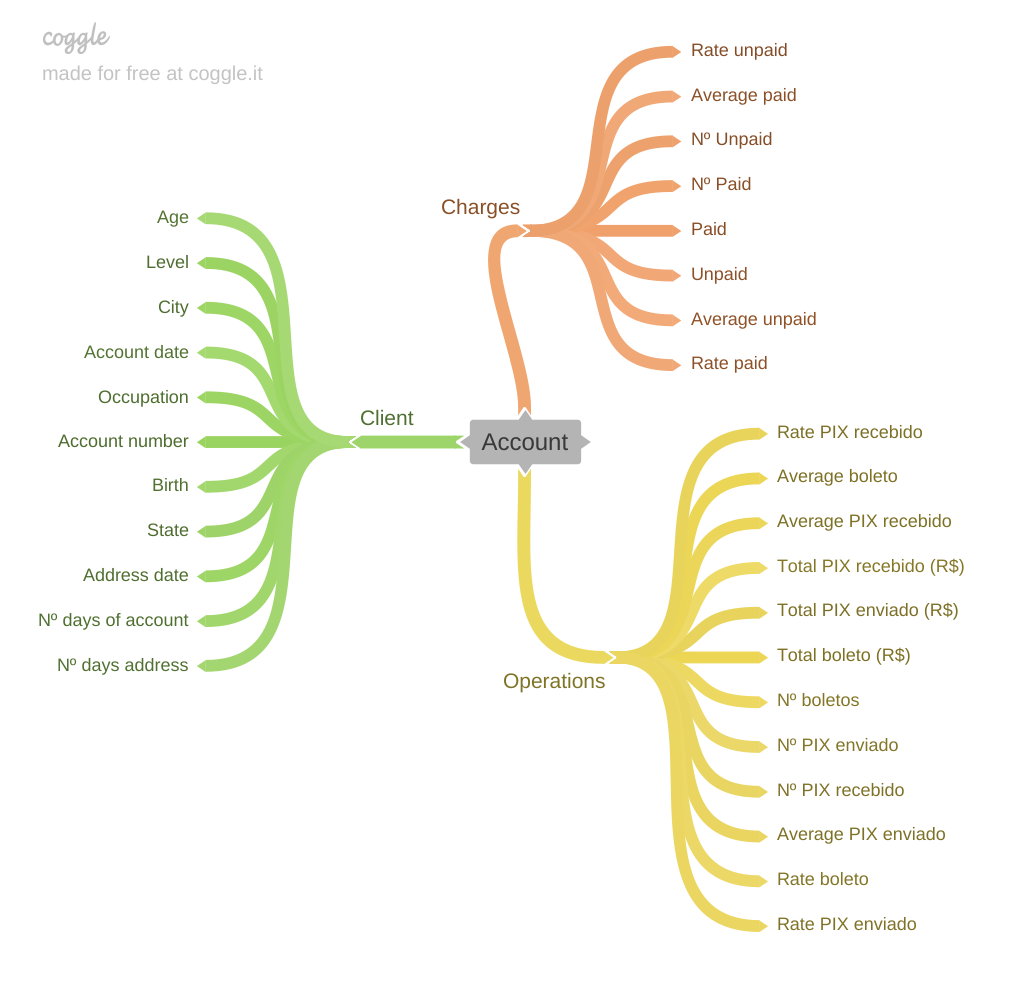

In [111]:
Image('../img/mind_map.png')

## Operations Hypothesis

    H1. The number of operations with PIX (recebido/ enviado) are high than boleto
    H2. The average of boleto are high than PIX
    H3. PIX recebido rate are higher
    H4. Total boleto (R$) are higher

## Client Hypothesis

    H1. Level A customers are the oldest
    H2. Level A customers have more account days
    H3. Level F customers have high unpaid charges
    H4. Level A customers have more address days

## Charges Hypothesis

    H1. Average paid are higher than unpaid
    H2. Unpaid rate are higher for customers level F
    H3. Number of paid are higher than unpaid

## Hypothesis List

    H1. The number of operations with PIX (recebido/ enviado) are high than boleto
    H2. The average of boleto are high than PIX
    H3. PIX recebido rate are higher
    H4. Total boleto (R$) are higher
    H5. Level A customers are the oldest
    H6. Level A customers have more account days
    H7. Level F customers have high unpaid charges
    H8. Average paid are higher than unpaid
    H9. Unpaid rate are higher for customers level F
    H10. Number of paid are higher than unpaid
    H11. Level A customers have more address days

## Feature Derived

### Client

In [35]:
# Age
df4['birth'] = pd.to_datetime(df4['birth'])
today = datetime.today()
df4['age'] = today.year - df4['birth'].dt.year

In [36]:
# Account days
df4['account_date'] = pd.to_datetime(df4['account_date'])
df4['account_days'] = df4['account_date'].dt.day

In [37]:
# Address days
df4['address_date'] = pd.to_datetime(df4['address_date'])
df4['address_days'] = df4['address_date'].dt.day

### Operations

In [38]:
# Rate pix recebido
df4['rate_pix_recebido'] = round(df4['num_pix_recebido'] / df4[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)

# Average pix recebido
df4['avg_pix_recebido'] = round(df4['total_pix_recebido'] / df4['num_pix_recebido'], 1) 

# Average boleto
df4['avg_boleto'] = round(df4['total_boleto'] / df4['num_boleto'], 1) 

# Rate boleto
df4['rate_boleto'] = round(df4['num_boleto'] / df4[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)

# Average pix enviado
df4['avg_pix_enviado'] = round(df4['total_pix_enviado'] / df4['num_pix_enviado'], 1) 

# Rate pix enviado 
df4['rate_pix_enviado'] = round(df4['num_pix_enviado'] / df4[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)

### Charges

In [39]:
#rate unpaid
df4['rate_unpaid'] = round(df4['unpaid'] / df4[['paid', 'unpaid']].sum(axis=1), 2)

#average unpaid
df4['avg_unpaid'] = round(df4['unpaid'] / df4['num_unpaid'], 2)

#average paid
df4['avg_paid'] = round(df4['paid'] / df4['num_paid'], 2)

#rage paid
df4['rate_paid'] = round(df4['paid'] / df4[['paid', 'unpaid']].sum(axis=1), 2)

### Fill NaN

In [41]:
df4['rate_pix_recebido'].fillna(0, inplace=True)  
df4['avg_pix_recebido'].fillna(0, inplace=True)  
df4['avg_boleto'].fillna(0, inplace=True)        
df4['rate_boleto'].fillna(0, inplace=True)       
df4['avg_pix_enviado'].fillna(0, inplace=True)   
df4['rate_pix_enviado'].fillna(0, inplace=True)  
df4['rate_unpaid'].fillna(0, inplace=True)       
df4['avg_unpaid'].fillna(0, inplace=True)        
df4['avg_paid'].fillna(0, inplace=True)          
df4['rate_paid'].fillna(0, inplace=True)         

### New Features Descriptions

In [170]:
tab = [
    ['Feature',             'Description'],
    ['age',                 'Age of customer'],
    ['account_days',        'Number the days of the account'],
    ['address_days',        'Number of days of address registration'],
    ['rate_pix_recebido',   'The proportion of PIX recebido in all transactions'],
    ['avg_pix_recebido',    'The average of PIX recebido'],
    ['avg_boleto',          'The average of boleto (R$)'],
    ['rate_boleto',         'The proportion of boleto in all transactions'],
    ['avg_pix_enviado',     'The average of PIX enviado'],
    ['rate_pix_enviado',    'The proportion of PIX enviado in all transactions'],
    ['rate_unpaid',         'The proportion of unpaid in all charges'],
    ['avg_unpaid',          'The average of charges unpaid'],
    ['avg_paid',            'The average of charges paid'],
    ['rate_paid',           'The proportion of paid in all charges']
]

print(tabulate(tab, tablefmt="fancy_grid"))

╒═══════════════════╤════════════════════════════════════════════════════╕
│ Feature           │ Description                                        │
├───────────────────┼────────────────────────────────────────────────────┤
│ age               │ Age of customer                                    │
├───────────────────┼────────────────────────────────────────────────────┤
│ account_days      │ Number the days of the account                     │
├───────────────────┼────────────────────────────────────────────────────┤
│ address_days      │ Number of days of address registration             │
├───────────────────┼────────────────────────────────────────────────────┤
│ rate_pix_recebido │ The proportion of PIX recebido in all transactions │
├───────────────────┼────────────────────────────────────────────────────┤
│ avg_pix_recebido  │ The average of PIX recebido                        │
├───────────────────┼────────────────────────────────────────────────────┤
│ avg_boleto        │ The

## Data Output

In [42]:
df4.to_csv('../data/df_feature_engineering.csv', index=False)

# Exploratory Data Analysis

## Data Input

In [43]:
df5 = pd.read_csv('../data/df_feature_engineering.csv')

## Univariate Analysis

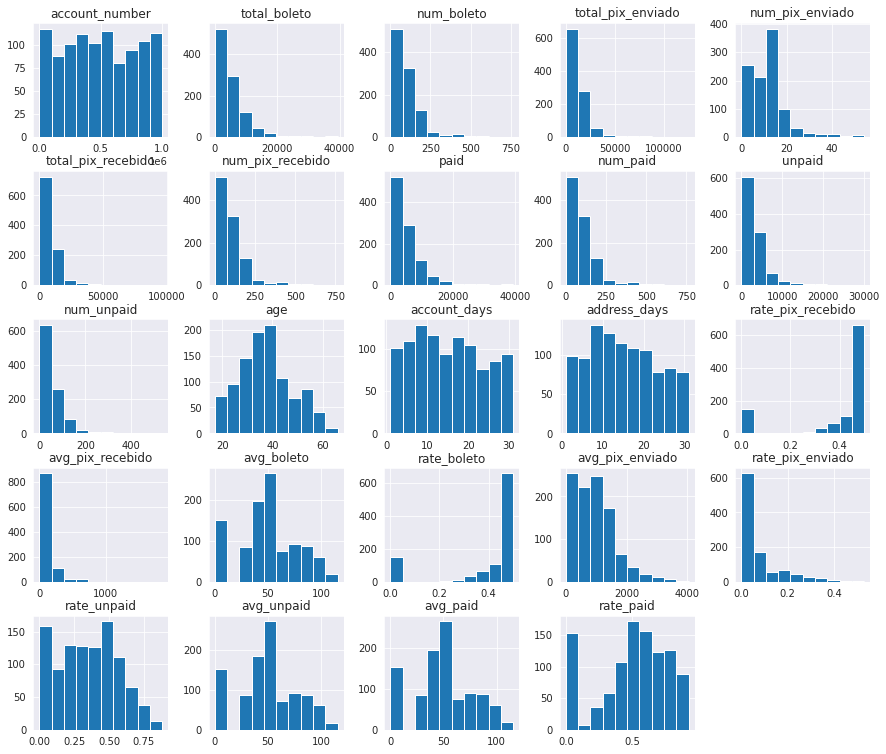

In [44]:
df5.hist(figsize=(15, 13))
plt.show()

    Have outliers
        1. total_boleto
        2. num_boleto
        3. total_pix_enviado
        4. total_pix recebido
        5. num_pix_recebido
        6. paid
        7. num_paid
        8. unpaid
        9. avg_pix_recebido

## Bivariate Analysis (Hypothesis Test)

### H1. The number of operations with PIX (recebido and enviado) are high than boleto

    Result: False
    Metric: Sum
    Note:   The number of boleto are higher than number of PIX enviado

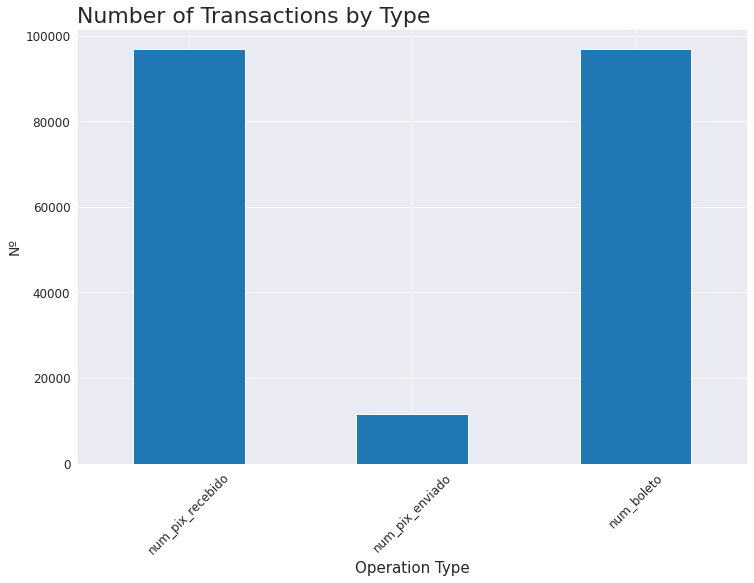

In [47]:
aux = df5[['num_pix_recebido', 'num_pix_enviado', 'num_boleto']].sum()
aux.plot(kind='bar')
graph_info_cat('Number of Transactions by Type', 'Operation Type', 'Nº', 45)

### H2. The average of boleto are high than PIX

    Result: False
    Metric: Average
    Note:   The average of boleto are smaller than PIX enviado

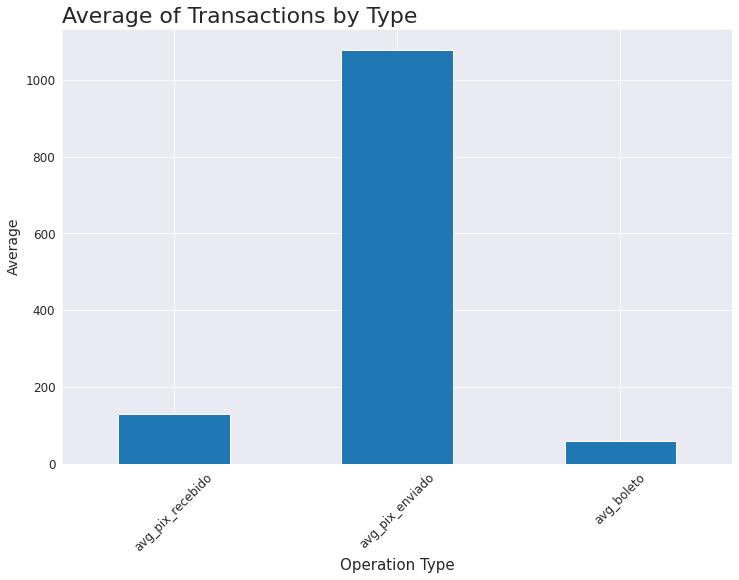

In [209]:
aux = df5[['avg_pix_recebido', 'avg_pix_enviado', 'avg_boleto']].mean()
aux.plot(kind='bar')
graph_info_cat('Average of Transactions by Type', 'Operation Type', 'Average', 45)

### H3. PIX recebido rate are higher
    
    Result: False
    Metric: Average
    Note:   The average rate of rate pix recebido and rate boleto are equal

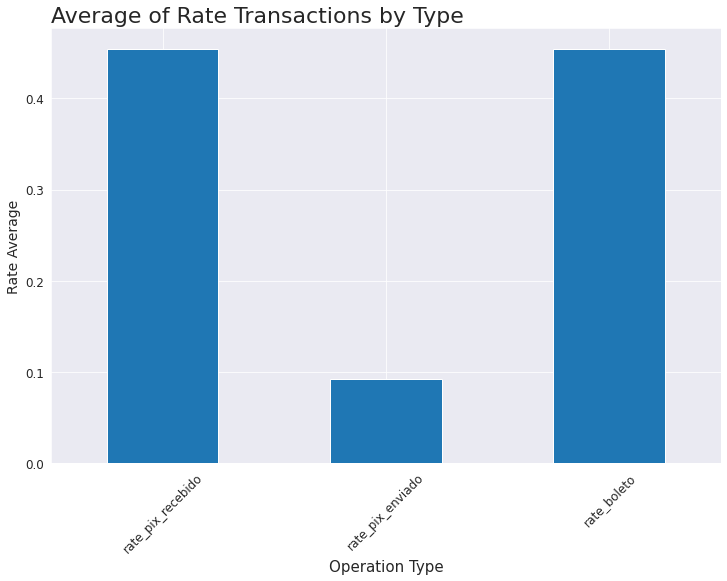

In [211]:
aux = df5[['rate_pix_recebido', 'rate_pix_enviado', 'rate_boleto']].mean()
aux.plot(kind='bar')
graph_info_cat('Average of Rate Transactions by Type', 'Operation Type', 'Rate Average', 45)

In [212]:
 df5[['rate_pix_recebido', 'rate_pix_enviado', 'rate_boleto']].mean()

rate_pix_recebido    0.454027
rate_pix_enviado     0.091957
rate_boleto          0.454027
dtype: float64

### H4. Total boleto (R$) are higher

    Result: False
    Metric: Amount
    Note:   The amount of total pix enviado are higher

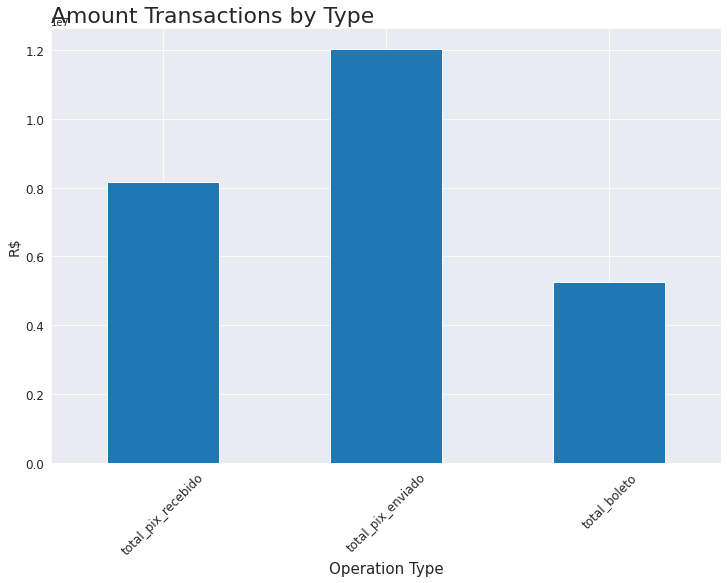

In [223]:
aux = df5[['total_pix_recebido', 'total_pix_enviado', 'total_boleto']].sum()
aux.plot(kind='bar')
graph_info_cat('Amount Transactions by Type', 'Operation Type', 'R$', 45)

In [224]:
df5[['total_pix_recebido', 'total_pix_enviado', 'total_boleto']].sum()

total_pix_recebido     8152314.63
total_pix_enviado     12025682.38
total_boleto           5256237.43
dtype: float64

### H5. Level A customers are the oldest
    
    Result: False
    Metric: Median
    Note:   The level C and B customers median age are higher    

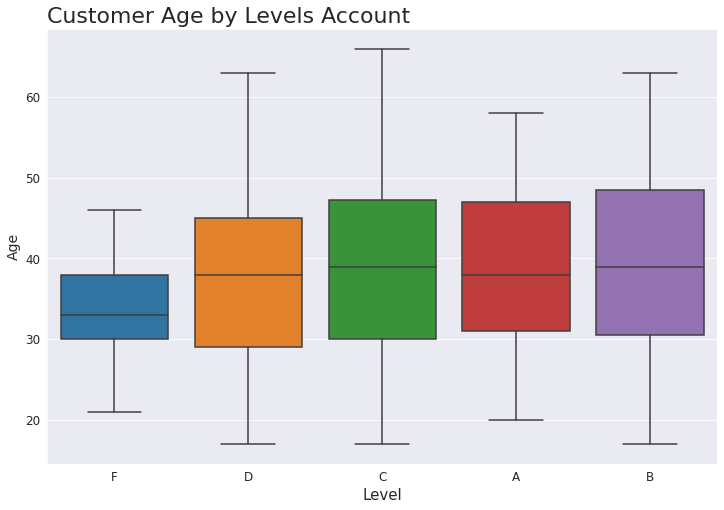

In [229]:
sns.boxplot(x='level', y='age', data=df5)
graph_info_cat('Customer Age by Levels Account', 'Level', 'Age')

### H6. Level A customers have more account days

    Result: False
    Metric: Median
    Note:   A level account's median days are shorter than other account levels  

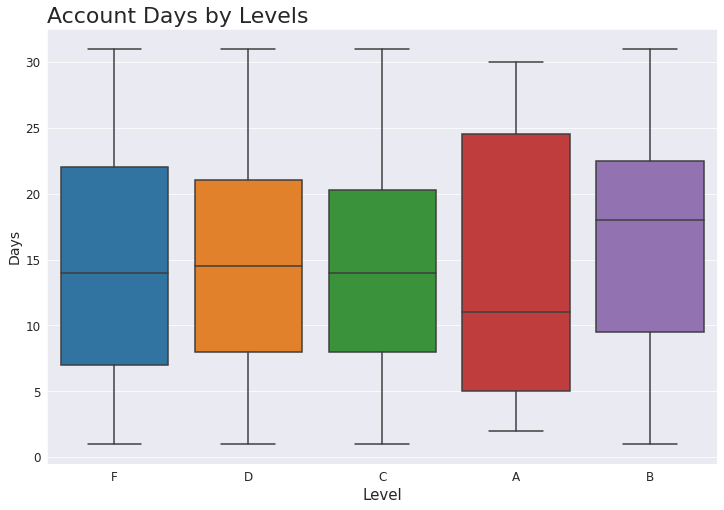

In [230]:
sns.boxplot(x='level', y='account_days', data=df5)
graph_info_cat('Account Days by Levels', 'Level', 'Days')

### H7. Level F customers have high unpaid charges

    Result: False
    Metric: Amount
    Note:   The unpaid amount of level D accounts is the highest

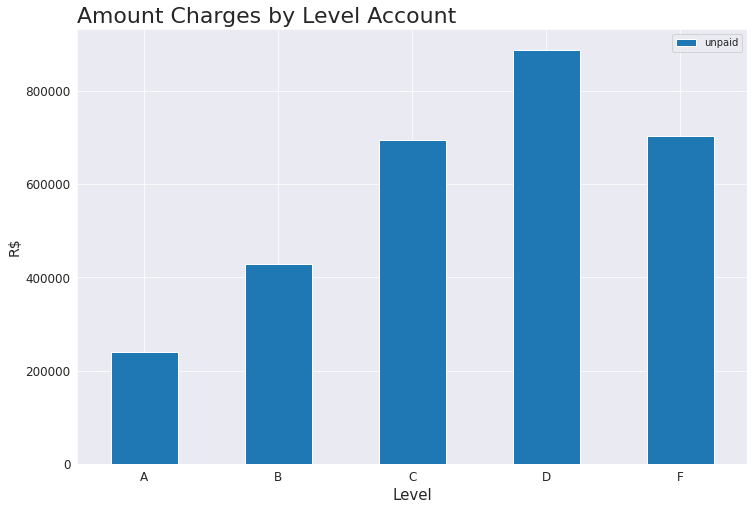

In [232]:
aux = df5[['unpaid', 'level']].groupby('level').sum()
aux.plot(kind='bar')
graph_info_cat('Amount Charges by Level Account', 'Level', 'R$')

In [235]:
aux.sort_values('unpaid', ascending=False)

,unpaid
level,
D,888474.88
F,702178.71
C,694999.53
B,428409.79
A,240843.97


### H8. Average paid are higher than unpaid

    Result: True
    Metric: Average
    Note:   The paid average is the highest

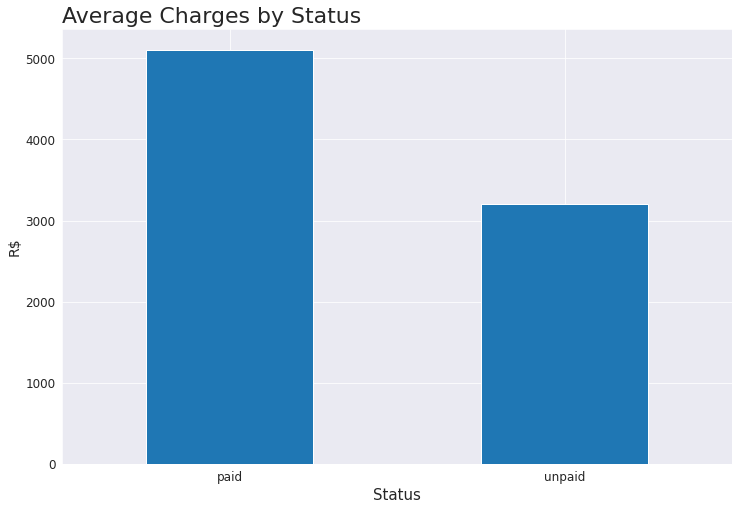

In [236]:
aux = df5[['paid', 'unpaid']].mean()
aux.plot(kind='bar')
graph_info_cat('Average Charges by Status', 'Status', 'R$')

### H9. Unpaid rate are higher for customers level F

    Result: True
    Metric: Median
    Note:   The first quartile of the F account level is higher than the median of the other levels.

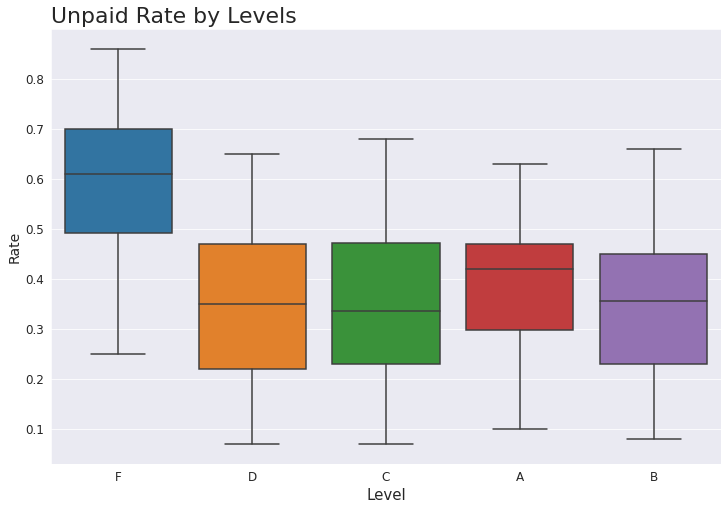

In [237]:
sns.boxplot(x='level', y='rate_unpaid', data=df5)
graph_info_cat('Unpaid Rate by Levels', 'Level', 'Rate')

### H10. Number of paid are higher than unpaid

    Result: True
    Metric: Amount
    Note:   The number of paid charges is higher

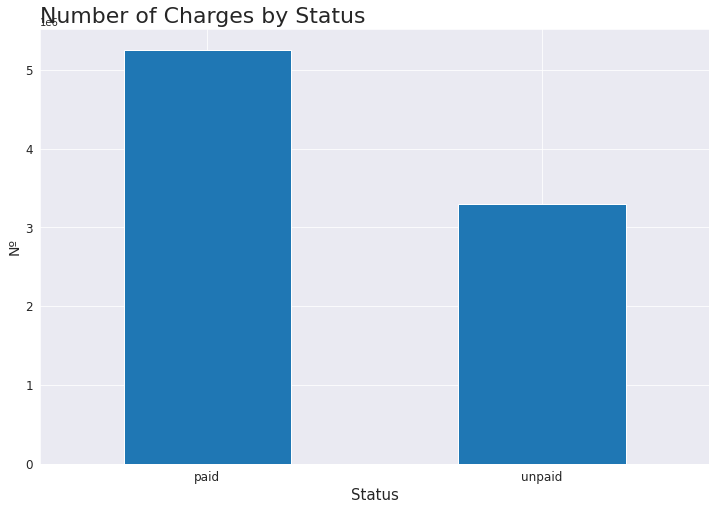

In [238]:
aux = df5[['paid', 'unpaid']].sum()
aux.plot(kind='bar')
graph_info_cat('Number of Charges by Status', 'Status', 'Nº')

### H11. Level A customers have more address days

    Result: False
    Metric: Median
    Note:   Account level B median address registration days are higher

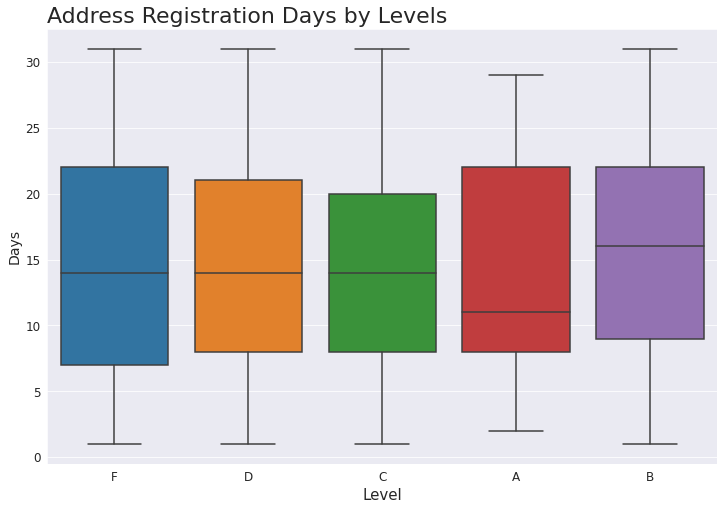

In [239]:
sns.boxplot(x='level', y='address_days', data=df5)
graph_info_cat('Address Registration Days by Levels', 'Level', 'Days')

### Hypothesis Result

In [6]:
tab = [
    ['Hypothesis',                                                                    'Result', 'Model Relevance'],
    ['H1. The number of operations with PIX (recebido/ enviado) are high than boleto','False',   'Low'],
    ['H2. The average of boleto are high than PIX',                                   'False',   'Low'],
    ['H3. PIX recebido rate are higher',                                              'False',   'Low'],
    ['H4. Total boleto (R$) are higher',                                              'False',   'Low'],
    ['H5. Level A customers are the oldest',                                          'False',   'Medium'],
    ['H6. Level A customers have more account days',                                  'False',   'Medium'],
    ['H7. Level F customers have high unpaid charges',                                'False',   'High'],
    ['H8. Average paid are higher than unpaid',                                       'True',    'Medium'],
    ['H9. Unpaid rate are higher for customers level F',                              'True',    'High'],
    ['H10. Number of paid are higher than unpaid',                                    'True',    'Medium'],
    ['H11. Level A customers have more address days',                                 'False',   'Low']
]

print(tabulate(tab, tablefmt="fancy_grid"))

╒════════════════════════════════════════════════════════════════════════════════╤════════╤═════════════════╕
│ Hypothesis                                                                     │ Result │ Model Relevance │
├────────────────────────────────────────────────────────────────────────────────┼────────┼─────────────────┤
│ H1. The number of operations with PIX (recebido/ enviado) are high than boleto │ False  │ Low             │
├────────────────────────────────────────────────────────────────────────────────┼────────┼─────────────────┤
│ H2. The average of boleto are high than PIX                                    │ False  │ Low             │
├────────────────────────────────────────────────────────────────────────────────┼────────┼─────────────────┤
│ H3. PIX recebido rate are higher                                               │ False  │ Low             │
├────────────────────────────────────────────────────────────────────────────────┼────────┼─────────────────┤
│ H4. Tota

## Multivariate Analysis

### Numerical

In [23]:
num_attributes = df5.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.iloc[:, 1:]

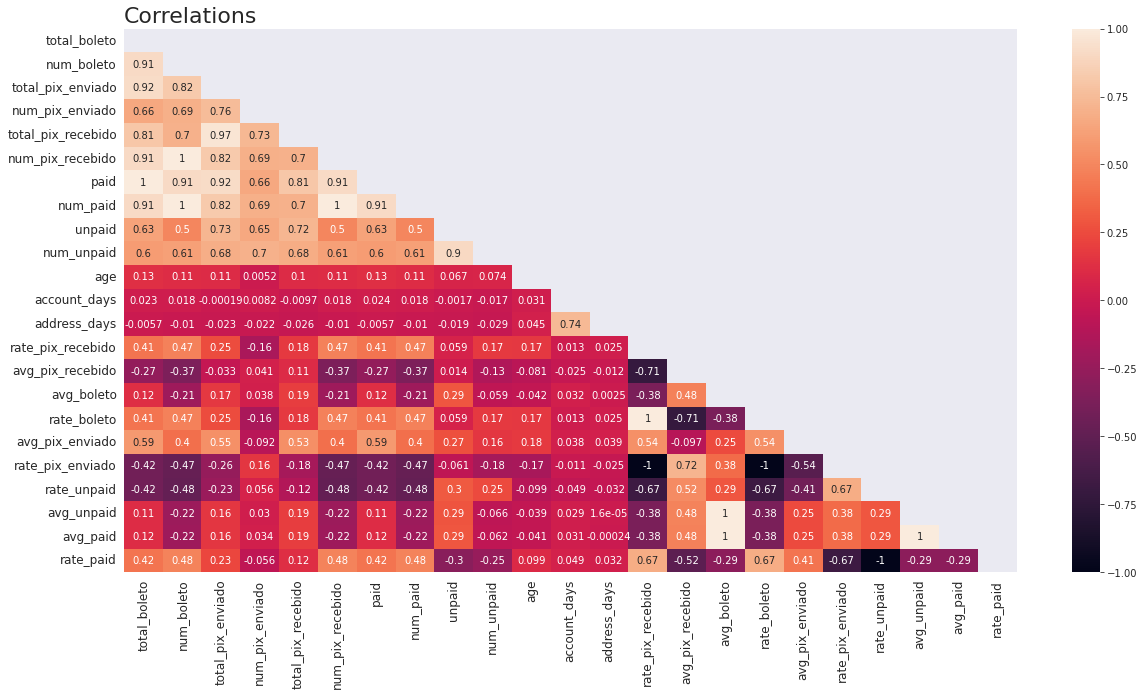

In [24]:
corr = num_attributes.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
sns.heatmap(corr, mask=mask, annot=True)
graph_info_cat('Correlations', x_rotation=90)

    Strong Positive Correlation
        avg_unpaid       | avg_paid
        avg_boleto       | avg_paid
        avg_boleto       | avg_unpaid
        rate_pix_enviado | rate_unpaid
        avg_pix_recebido | rate_pix_enviado
        rate_pix_recebido| rate_boleto
        account_days     | address_days
    
    Strong negative correlation
        rate_boleto      | rate_pix_enviado
        rate_unpaid      | rate_unpaid
        rate_pix_recebido| rate_pix_enviado
        
        
Some columns need to be dropped

### Categoricals

In [26]:
cat_attributes = df5.select_dtypes(include=['object'])

In [31]:
print('Proportion (%) of level by state')
round(pd.crosstab(cat_attributes['state'], cat_attributes['level'], normalize='columns'), 1)

Proportion (%) of level by state


level,A,B,C,D,F
state,,,,,
BA,0.0,0.1,0.1,0.1,0.0
ES,0.2,0.2,0.1,0.1,0.1
GO,0.1,0.0,0.1,0.1,0.0
MG,0.3,0.3,0.4,0.4,0.1
PR,0.1,0.1,0.1,0.1,0.5
RJ,0.1,0.2,0.1,0.1,0.3
SC,0.1,0.1,0.1,0.0,0.0
SP,0.1,0.1,0.1,0.1,0.0


    Proportions seem balanced by level.

In [32]:
print('Proportion (%) of level by occupation')
round(pd.crosstab(cat_attributes['occupation'], cat_attributes['level'], normalize='columns'), 1)

Proportion (%) of level by occupation


level,A,B,C,D,F
occupation,,,,,
Analista,0.1,0.3,0.3,0.3,0.0
Autonomo,0.0,0.0,0.0,0.1,0.1
Corretor,0.2,0.3,0.2,0.2,0.2
Desenvolvedor,0.4,0.3,0.2,0.3,0.1
Investidor,0.1,0.1,0.1,0.1,0.2
Outros,0.2,0.1,0.1,0.1,0.4


    40% of the occupation equal to "Outros" is of level F
    40% of the occupation equal to "Desenvolvedor" is of level A

# Data Filtering

## Input Data

In [48]:
df6 = pd.read_csv('../data/df_feature_engineering.csv')

## Drop date columns

In [49]:
df6.drop(columns=['birth', 'account_date', 'address_date'], inplace=True)

## Data Output

In [50]:
df6.to_csv('../data/df_filter.csv', index=False)

# Data Preparation

## Data Input

In [87]:
df7 = pd.read_csv('../data/processed/df_filter.csv')

## Train, Validation and Test Split

In [88]:
# Test
test = df7[df7['level'].isnull() == True].reset_index(drop=True)

In [89]:
# Train and validation
train_validation = df7[~df7['level'].isnull()].reset_index(drop=True)

X = train_validation.drop(columns='level')
y = train_validation[['level']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

## Encoder

In [83]:
#---------------------------------Train-----------------------------------
# occupation | Label encoding
le = LabelEncoder()
X_train.loc[:, 'occupation'] = le.fit_transform(X_train['occupation'])

# state | Frequecy encoding
freq_state_train = round(X_train.groupby('state').size() / len(X_train), 2)
X_train.loc[:, 'state'] = X_train['state'].map(freq_state_train)

# city | Frequecy encoding
freq_city_train = round(X_train.groupby('city').size() / len(X_train), 4)
X_train.loc[:, 'city'] = X_train['city'].map(freq_city_train)

# level | Ordinal
oe = OrdinalEncoder()
y_train = oe.fit_transform(y_train.values.reshape(-1, 1))
pickle.dump(oe, open('../data/models/level_encoder.pkl', 'wb'))

#---------------------------------Validation-----------------------------------
X_val.loc[:, 'occupation'] = le.fit_transform(X_val['occupation'])

# state | Frequecy encoding
freq_state_val = round(X_val.groupby('state').size() / len(X_val), 2)
X_val.loc[:, 'state'] = X_val['state'].map(freq_state_val)

# city | Frequecy encoding
freq_city_val = round(X_val.groupby('city').size() / len(X_val), 4)
X_val.loc[:, 'city'] = X_val['city'].map(freq_city_val)

# level | Ordinal
#y_val = oe.fit_transform(y_val.values.reshape(-1, 1))

## Rescaling

    MinMax

    Robust

    Standard

In [84]:
#----------------------------------------Train----------------------------------
#========================================Robust Scaler==========================
rs = RobustScaler()

# total_boleto
X_train['total_boleto'] = rs.fit_transform(X_train[['total_boleto']])

# num_boleto
X_train['num_boleto'] = rs.fit_transform(X_train[['num_boleto']])

# total_pix_enviado
X_train['total_pix_enviado'] = rs.fit_transform(X_train[['total_pix_enviado']])

# total_pix_recebido 
X_train['total_pix_recebido'] = rs.fit_transform(X_train[['total_pix_recebido']])

# num_pix_recebido 
X_train['num_pix_recebido'] = rs.fit_transform(X_train[['num_pix_recebido']])

# paid 
X_train['paid'] = rs.fit_transform(X_train[['paid']])

# num_paid
X_train['num_paid'] = rs.fit_transform(X_train[['num_paid']])

#unpaid
X_train['unpaid'] = rs.fit_transform(X_train[['unpaid']])

# num_unpaid 
X_train['num_unpaid'] = rs.fit_transform(X_train[['num_unpaid']])

# avg_pix_recebido
X_train['avg_pix_recebido'] = rs.fit_transform(X_train[['avg_pix_recebido']])

# avg_pix_enviado 
X_train['avg_pix_enviado'] = rs.fit_transform(X_train[['avg_pix_enviado']])

#=======================================Standard Scaler=============================
ss = StandardScaler()

# num_pix_enviado
X_train['num_pix_enviado'] = ss.fit_transform(X_train[['num_pix_enviado']])

#=======================================Min Max=====================================
mm = MinMaxScaler()
# age 
X_train['age'] = mm.fit_transform(X_train[['age']])

# account_days 
X_train['account_days'] = mm.fit_transform(X_train[['account_days']])

# address_days
X_train['address_days'] = mm.fit_transform(X_train[['address_days']])

# avg_boleto
X_train['avg_boleto'] = mm.fit_transform(X_train[['avg_boleto']])

# avg_unpaid
X_train['avg_unpaid'] = mm.fit_transform(X_train[['avg_unpaid']])

# avg_paid
X_train['avg_paid'] = mm.fit_transform(X_train[['avg_paid']])

In [85]:
#-------------------------------------------Validation----------------------------------
#========================================Robust Scaler==========================
rs = RobustScaler()

# total_boleto
X_val['total_boleto'] = rs.fit_transform(X_val[['total_boleto']])

# num_boleto
X_val['num_boleto'] = rs.fit_transform(X_val[['num_boleto']])

# total_pix_enviado
X_val['total_pix_enviado'] = rs.fit_transform(X_val[['total_pix_enviado']])

# total_pix_recebido 
X_val['total_pix_recebido'] = rs.fit_transform(X_val[['total_pix_recebido']])

# num_pix_recebido 
X_val['num_pix_recebido'] = rs.fit_transform(X_val[['num_pix_recebido']])

# paid 
X_val['paid'] = rs.fit_transform(X_val[['paid']])

# num_paid
X_val['num_paid'] = rs.fit_transform(X_val[['num_paid']])

#unpaid
X_val['unpaid'] = rs.fit_transform(X_val[['unpaid']])

# num_unpaid 
X_val['num_unpaid'] = rs.fit_transform(X_val[['num_unpaid']])

# avg_pix_recebido
X_val['avg_pix_recebido'] = rs.fit_transform(X_val[['avg_pix_recebido']])

# avg_pix_enviado 
X_val['avg_pix_enviado'] = rs.fit_transform(X_val[['avg_pix_enviado']])

#=======================================Standard Scaler=============================
ss = StandardScaler()

# num_pix_enviado
X_val['num_pix_enviado'] = ss.fit_transform(X_val[['num_pix_enviado']])

#=======================================Min Max=====================================
mm = MinMaxScaler()
# age 
X_val['age'] = mm.fit_transform(X_val[['age']])

# account_days 
X_val['account_days'] = mm.fit_transform(X_val[['account_days']])

# address_days
X_val['address_days'] = mm.fit_transform(X_val[['address_days']])

# avg_boleto
X_val['avg_boleto'] = mm.fit_transform(X_val[['avg_boleto']])

# avg_unpaid
X_val['avg_unpaid'] = mm.fit_transform(X_val[['avg_unpaid']])

# avg_paid
X_val['avg_paid'] = mm.fit_transform(X_val[['avg_paid']])

## Data Output

In [90]:
# Train
X_train.to_csv('../data/processed/X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('../data/y_train.csv', index=False)

# Val
X_val.to_csv('../data/processed/X_val.csv', index=False)
pd.DataFrame(y_val).to_csv('../data/processed/y_val.csv', index=False)

# Test
test.to_csv('../data/processed/test.csv', index=False)

# Feature Selection

## Input Data

In [138]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')

X_val = pd.read_csv('../data/X_val.csv')

## Boruta

In [121]:
# Estimator
rf = RandomForestClassifier(n_jobs=-1)

# Data
X_train_b = X_train.drop(columns='account_number').values.copy()
y_train_b = y_train.values.ravel().copy()

# Selector
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=7).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	11
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	11
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	11
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	11
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	10
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	9
Rejected: 	8
Itera

In [128]:
# Cols selected
boruta.support_

array([False, False, False, False, False,  True,  True, False,  True,
       False,  True, False, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False])

In [129]:
# Drop account number
cols_selected = X_train.drop(columns='account_number').columns
cols_selected[boruta.support_]

Index(['total_pix_enviado', 'num_pix_enviado', 'num_pix_recebido', 'num_paid',
       'rate_pix_recebido', 'rate_boleto', 'avg_pix_enviado',
       'rate_pix_enviado', 'rate_unpaid', 'avg_unpaid', 'avg_paid'],
      dtype='object')

## Importance

In [140]:
# Data 
x_train_t = X_train.drop(columns='account_number').copy()
y_train_t = y_train.values.ravel().copy()

# Fit
rf.fit(x_train_t, y_train_t)

RandomForestClassifier(n_estimators=50, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x7F93A905FC40)

Feature ranking:
              feature  importances
0    rate_pix_enviado     0.096698
0                 age     0.055003
0         rate_unpaid     0.051129
0        address_days     0.047575
0        account_days     0.046549
0     avg_pix_enviado     0.046320
0     num_pix_enviado     0.044223
0          occupation     0.040978
0    avg_pix_recebido     0.037933
0            avg_paid     0.037318
0            num_paid     0.036240
0          avg_boleto     0.036082
0          num_boleto     0.035827
0          avg_unpaid     0.035400
0    num_pix_recebido     0.033210
0   total_pix_enviado     0.032926
0               state     0.032508
0                paid     0.031739
0  total_pix_recebido     0.031457
0        total_boleto     0.031144
0              unpaid     0.030483
0          num_unpaid     0.030370
0         rate_boleto     0.030021
0   rate_pix_recebido     0.026429
0           rate_paid     0.022635
0                city     0.019803


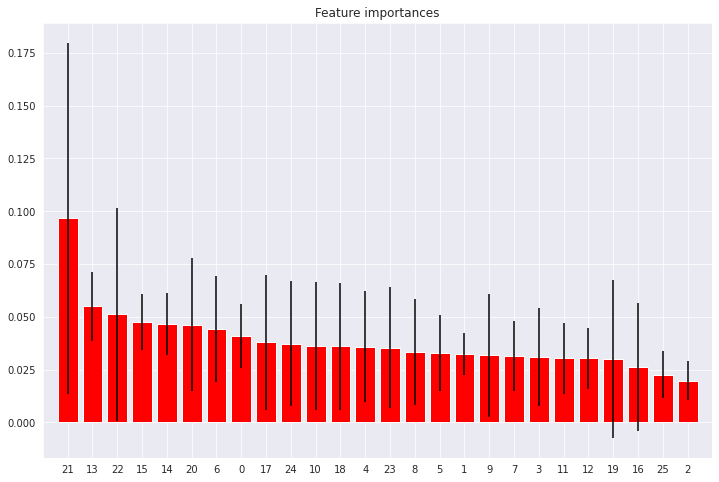

In [141]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_t, rf.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importances', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_t.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_t.shape[1]), indices)
plt.xlim([-1, x_train_t.shape[1]])
plt.show()

## Data Output

In [144]:
# Columns selected by boruta + account_number
cols_selected_boruta = ['account_number', 'total_pix_enviado', 'num_pix_enviado', 'num_pix_recebido', 'num_paid', 
                        'rate_pix_recebido', 'rate_boleto', 'avg_pix_enviado', 'rate_pix_enviado', 'rate_unpaid', 'avg_unpaid', 
                        'avg_paid']

X_train.loc[:, cols_selected_boruta].to_csv('../data/X_train_feature_selection.csv', index=False)
X_val.loc[:, cols_selected_boruta].to_csv('../data/X_val_feature_selection.csv', index=False)

# Machine Learning

## Data Input

In [5]:
X_train = pd.read_csv('../data/processed/X_train_feature_selection.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_val = pd.read_csv('../data/processed/X_val_feature_selection.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')

# Label Encoder
oe = pickle.load(open('../data/models/level_encoder.pkl', 'rb'))

## Baseline (Dummy)

Balanced Accuracy: 0.19
Kappa Score: 0.01


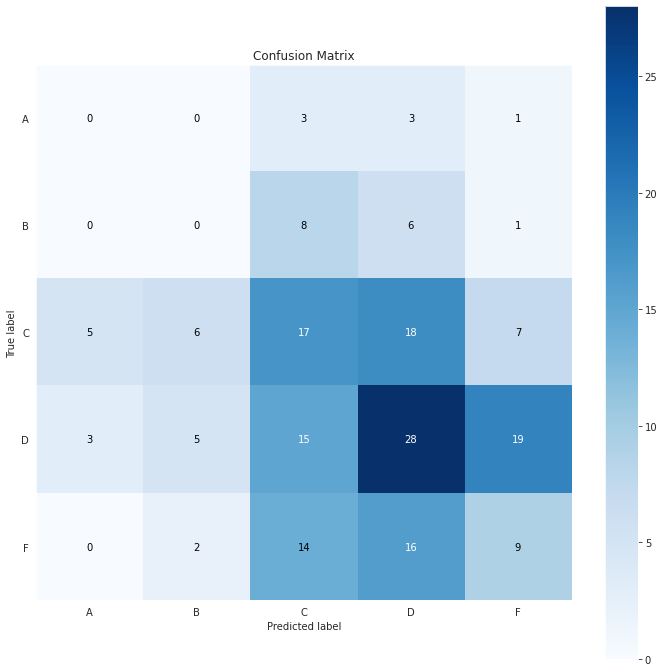

In [95]:
# Model Definition
dc = DummyClassifier(strategy='stratified', random_state=7)

# Model training
dummy_model = dc.fit(X_train, y_train)

# Predict
pred = dummy_model.predict(X_val)

# Inverse Order Encoder
yhat = oe.inverse_transform(pred.reshape(-1, 1))

# Model Performance
## Balanced Accuray
bcs = round(balanced_accuracy_score(y_val, yhat), 2)
print(f'Balanced Accuracy: {bcs}')

## Kappa Metrics
cks = round(cohen_kappa_score(y_val, yhat), 2)
print(f'Kappa Score: {cks}')

## Confusion Matrix
plot_confusion_matrix(y_val, yhat, normalize=False, figsize=(12,12))
plt.show()

## Logistic Regression

Balanced Accuracy: 0.2
Kappa Score: 0.0


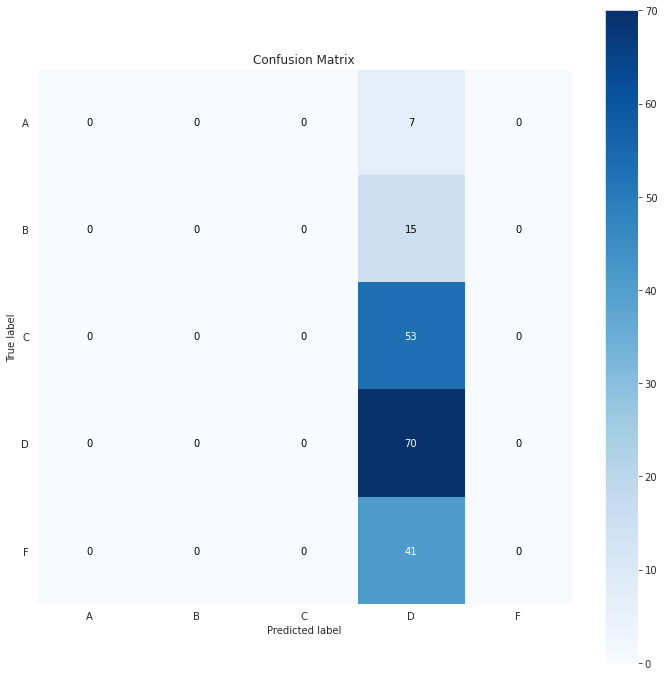

In [108]:
model_performance(LogisticRegression(random_state=7), X_train, y_train.values.ravel(), X_val, y_val, ordinal_encoder=oe)

## Decision Tree

Balanced Accuracy: 0.44
Kappa Score: 0.31


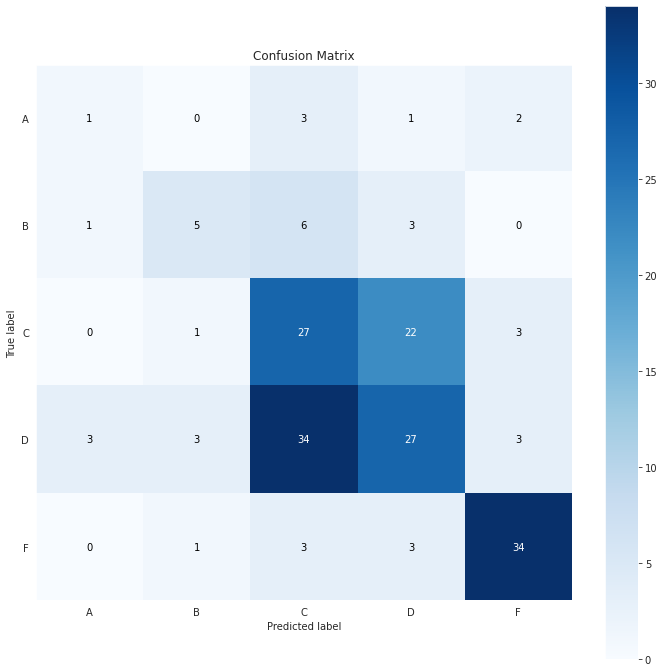

In [106]:
model_performance(DecisionTreeClassifier(random_state=7), X_train, y_train, X_val, y_val, ordinal_encoder=oe)

### Decision Tree Cross-Validation

In [162]:
model_performance_cv(model=DecisionTreeClassifier(random_state=7), num_folds=5, X_train=X_train, y_train=y_train)

Kfold: 1
Balanced Accuracy: 0.49
Kappa Score: 0.36

Kfold: 2
Balanced Accuracy: 0.37
Kappa Score: 0.24

Kfold: 3
Balanced Accuracy: 0.33
Kappa Score: 0.24

Kfold: 4
Balanced Accuracy: 0.39
Kappa Score: 0.28

Kfold: 5
Balanced Accuracy: 0.45
Kappa Score: 0.32

Results
Balanced Accuracy: 0.41 ± 0.06
Kappa Score: 0.29 ± 0.05



## Random Forest

Balanced Accuracy: 0.43
Kappa Score: 0.33


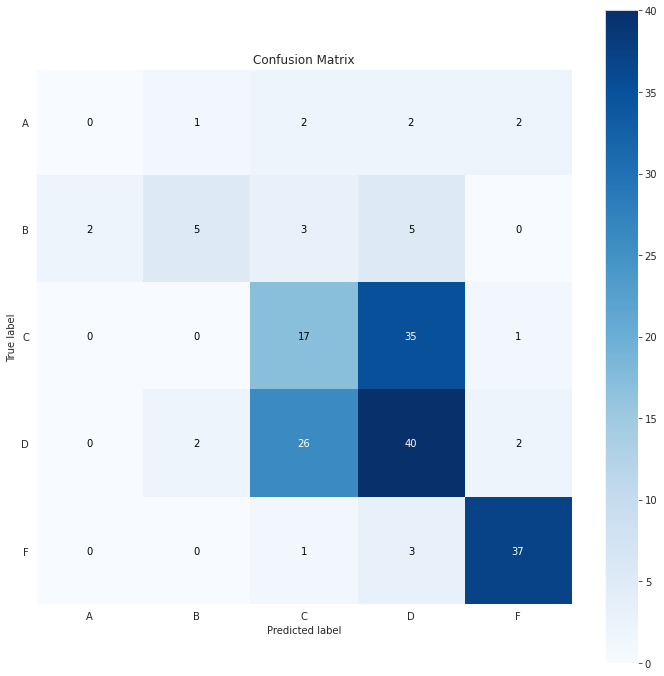

In [7]:
model_performance(RandomForestClassifier(random_state=7), X_train, y_train.values.ravel(), 
                  X_val, y_val, ordinal_encoder=oe)

### Random Forest Cross-Validation

In [163]:
model_performance_cv(model=RandomForestClassifier(random_state=7), num_folds=5, X_train=X_train, y_train=y_train)

Kfold: 1
Balanced Accuracy: 0.53
Kappa Score: 0.38

Kfold: 2
Balanced Accuracy: 0.4
Kappa Score: 0.32

Kfold: 3
Balanced Accuracy: 0.37
Kappa Score: 0.32

Kfold: 4
Balanced Accuracy: 0.42
Kappa Score: 0.34

Kfold: 5
Balanced Accuracy: 0.43
Kappa Score: 0.36

Results
Balanced Accuracy: 0.43 ± 0.05
Kappa Score: 0.34 ± 0.02



## SVM

Balanced Accuracy: 0.2
Kappa Score: 0.0


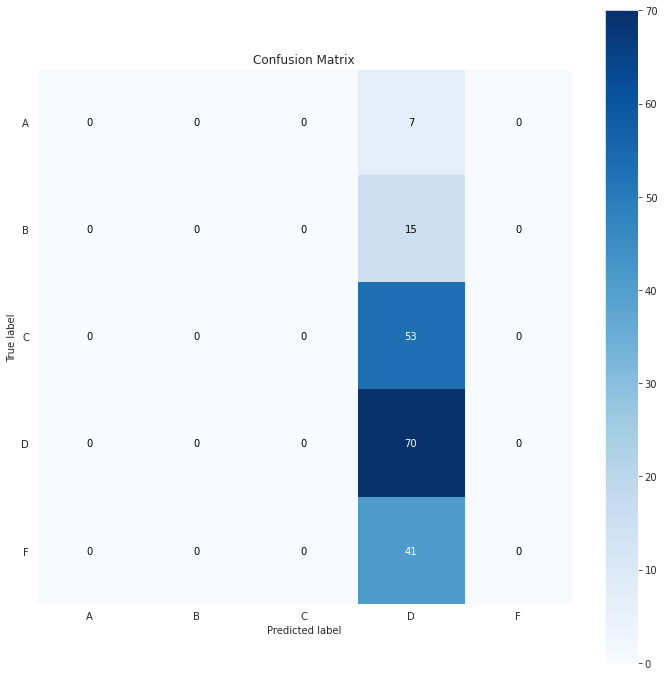

In [158]:
model_performance(SVC(random_state=7), X_train, y_train.values.ravel(), X_val, y_val, ordinal_encoder=oe)

# RF - Hyperparameter Fine Tuning

In [157]:
param = {
    'n_estimators': [100, 500, 1000, 2000, 3000],
    'max_depth': [3, 5, 9]}

MAX_EVAL = 5

final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print('------------------------------------')
    print( hp )
    print('------------------------------------')
    
    # model
    model_rfc = RandomForestClassifier(n_estimators=hp['n_estimators'], max_depth=hp['max_depth'], random_state=7)
                     

    # performance
    model_performance_cv(model=model_rfc, num_folds=5, X_train=X_train, y_train=y_train, verbose_sintetic=True)

------------------------------------
{'n_estimators': 3000, 'max_depth': 5}
------------------------------------
Balanced Accuracy: 0.44 ± 0.03
Kappa Score: 0.38 ± 0.03

------------------------------------
{'n_estimators': 1000, 'max_depth': 3}
------------------------------------
Balanced Accuracy: 0.43 ± 0.02
Kappa Score: 0.37 ± 0.03

------------------------------------
{'n_estimators': 2000, 'max_depth': 9}
------------------------------------
Balanced Accuracy: 0.44 ± 0.04
Kappa Score: 0.37 ± 0.04

------------------------------------
{'n_estimators': 500, 'max_depth': 3}
------------------------------------
Balanced Accuracy: 0.43 ± 0.02
Kappa Score: 0.37 ± 0.03

------------------------------------
{'n_estimators': 2000, 'max_depth': 9}
------------------------------------
Balanced Accuracy: 0.44 ± 0.04
Kappa Score: 0.37 ± 0.04



In [ ]:
# Best Random Parameters
# n_estimators = 3000
# max_depth    = 5

# Deploy

## Data Input

In [9]:
df11 = pd.read_csv('../data/raw/data_raw.csv')
df11.head()

,account_number,birth,occupation,account_date,state,city,address_date,level,total_boleto,num_boleto,total_pix_enviado,num_pix_enviado,total_pix_recebido,num_pix_recebido,paid,num_paid,unpaid,num_unpaid
0,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,Carmo,2021-04-01 02:30:00,F,342450.0,30.0,1016692.0,15.0,754686.0,66.0,342450.0,30.0,431396.0,39.0
1,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,Bertopolis,2021-04-01 02:00:00,D,375256.0,113.0,625227.0,10.0,566775.0,172.0,375256.0,113.0,512667.0,153.0
2,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,Olaria,2021-04-01 11:30:00,NaN,349747.0,64.0,1175602.0,8.0,860634.0,156.0,349747.0,64.0,426241.0,79.0
3,66402,1982-06-30,Investidor,2021-04-01 14:30:00,PR,Icaraima,2021-04-01 14:30:00,D,1341064.0,184.0,1321193.0,5.0,1221423.0,166.0,1341064.0,184.0,247459.0,33.0
4,277012,1967-01-11,Outros,2021-04-02 15:30:00,ES,Ecoporanga,2021-04-02 15:30:00,D,455390.0,90.0,1153644.0,9.0,796732.0,159.0,455390.0,90.0,569580.0,112.0


## Class Classification Model

In [63]:
class AccountLevel:
    '''
    --> Define the level account of a customer
    '''
    def __init__(self, data=None, level_defined=None, level_undefined=None, level_encoder=None):
        '''
        :param DataFrame data:            File to train the model and define de account level
        :param DataFrame level_defined:   Data with level account previousle defined
        :param DataFrame level_undefined: Data with level account undefined
        :param Object level_encoder:      Object to decode level account
        '''
        self._data            = data
        self._level_defined   = level_defined
        self._level_undefined  = level_undefined
    
    
    def data_clean(self):
        '''
        Fill NaN and change data types
        '''
        # Fill Nan
        self._data['total_boleto'].fillna(0, inplace=True)
        self._data['num_boleto'].fillna(0, inplace=True)
        self._data['total_pix_enviado'].fillna(0, inplace=True)
        self._data['num_pix_enviado'].fillna(0, inplace=True)
        self._data['total_pix_recebido'].fillna(0, inplace=True)
        self._data['num_pix_recebido'].fillna(0, inplace=True)
        self._data['paid'].fillna(0, inplace=True)
        self._data['num_paid'].fillna(0, inplace=True)
        self._data['unpaid'].fillna(0, inplace=True)
        self._data['num_unpaid'].fillna(0, inplace=True)        
        # Cents to real
        self._data['total_boleto']       = self._data['total_boleto'] / 100
        self._data['total_pix_enviado']  = self._data['total_pix_enviado'] / 100
        self._data['total_pix_recebido'] = self._data['total_pix_recebido'] / 100
        self._data['paid']               = self._data['paid'] / 100
        self._data['unpaid']             = self._data['unpaid'] / 100
        # Data types
        self._data['num_boleto']         = self._data['num_boleto'].astype('int64')
        self._data['num_pix_enviado']    = self._data['num_pix_enviado'].astype('int64')
        self._data['num_pix_recebido']   = self._data['num_boleto'].astype('int64')
        self._data['num_paid']           = self._data['num_paid'].astype('int64')
        self._data['num_unpaid']         = self._data['num_unpaid'].astype('int64')
    
    
    def feature_engineering(self):    
        '''
        --> Derive new features
        '''
        # New features
        self._data['rate_pix_recebido'] = round(self._data['num_pix_recebido']   / self._data[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)
        self._data['rate_boleto']       = round(self._data['num_boleto']         / self._data[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)
        self._data['avg_pix_enviado']   = round(self._data['total_pix_enviado']  / self._data['num_pix_enviado'], 1) 
        self._data['rate_pix_enviado']  = round(self._data['num_pix_enviado']    / self._data[['num_boleto', 'num_pix_enviado', 'num_pix_recebido']].sum(axis=1), 2)
        self._data['rate_unpaid']       = round(self._data['unpaid']             / self._data[['paid', 'unpaid']].sum(axis=1), 2)
        self._data['avg_unpaid']        = round(self._data['unpaid']             / self._data['num_unpaid'], 2)
        self._data['avg_paid']          = round(self._data['paid']               / self._data['num_paid'], 2)
        ### Fill NaN
        self._data['rate_pix_recebido'].fillna(0, inplace=True)  
        self._data['rate_boleto'].fillna(0, inplace=True)       
        self._data['avg_pix_enviado'].fillna(0, inplace=True)   
        self._data['rate_pix_enviado'].fillna(0, inplace=True)  
        self._data['rate_unpaid'].fillna(0, inplace=True)       
        self._data['avg_unpaid'].fillna(0, inplace=True)        
        self._data['avg_paid'].fillna(0, inplace=True)          
    
                
    def feature_selection(self):
        '''
        --> Feature selection and fill NaN
        '''
        columns = ['account_number', 'total_pix_enviado', 'num_pix_enviado', 'num_pix_recebido', 'num_paid', 'rate_pix_recebido',
                   'rate_boleto', 'avg_pix_enviado', 'rate_pix_enviado', 'rate_unpaid', 'avg_unpaid', 'avg_paid', 'level']
        self._data = self._data[columns]
    
    
    def data_split(self):
        '''
        --> Split the data with level defined and undefined
        '''
        # Undefined
        self._level_undefined = self._data[self._data['level'].isnull() == True].reset_index(drop=True)
        # Defined
        self._level_defined = self._data[~self._data['level'].isnull()].reset_index(drop=True)
        
    
    def data_preparation(self):
        '''
        --> Prepare the data to modeling
        '''     
        # Level Defined
        # level | Ordinal
        self._level_encoder = OrdinalEncoder()
        self._level_defined['level'] = self._level_encoder.fit_transform(self._level_defined['level'].values.reshape(-1, 1))
        #RobustScaler
        rs = RobustScaler()                
        self._level_defined['total_pix_enviado'] = rs.fit_transform(self._level_defined[['total_pix_enviado']])         
        self._level_defined['num_pix_recebido']  = rs.fit_transform(self._level_defined[['num_pix_recebido']])        
        self._level_defined['num_paid']          = rs.fit_transform(self._level_defined[['num_paid']])                        
        self._level_defined['avg_pix_enviado']   = rs.fit_transform(self._level_defined[['avg_pix_enviado']])
        #StandardScaler
        ss = StandardScaler()
        self._level_defined['num_pix_enviado'] = ss.fit_transform(self._level_defined[['num_pix_enviado']])
        #MinMax
        mm = MinMaxScaler()
        self._level_defined['avg_unpaid'] = mm.fit_transform(self._level_defined[['avg_unpaid']])
        self._level_defined['avg_paid']   = mm.fit_transform(self._level_defined[['avg_paid']])
        
        # Level undefined
        #RobustScaler
        rs = RobustScaler()                
        self._level_undefined['total_pix_enviado'] = rs.fit_transform(self._level_undefined[['total_pix_enviado']])         
        self._level_undefined['num_pix_recebido']  = rs.fit_transform(self._level_undefined[['num_pix_recebido']])        
        self._level_undefined['num_paid']          = rs.fit_transform(self._level_undefined[['num_paid']])                        
        self._level_undefined['avg_pix_enviado']   = rs.fit_transform(self._level_undefined[['avg_pix_enviado']])
        #StandardScaler
        ss = StandardScaler()
        self._level_undefined['num_pix_enviado'] = ss.fit_transform(self._level_undefined[['num_pix_enviado']])
        #MinMax
        mm = MinMaxScaler()
        self._level_undefined['avg_unpaid'] = mm.fit_transform(self._level_undefined[['avg_unpaid']])
        self._level_undefined['avg_paid']   = mm.fit_transform(self._level_undefined[['avg_paid']])
    
    
    def model_classification(self):
        '''
        --> Define level account and save csv file with 1 to ilicit and 0 to licit account
        '''
        model = RandomForestClassifier(n_estimators=3000, max_depth=5, random_state=7)
        X = self._level_defined.drop(columns=['account_number', 'level'])
        y = self._level_defined['level']
        to_predict = self._level_undefined.drop(columns=['account_number', 'level'])
        model.fit(X, y)
        pred = model.predict(to_predict)
        yhat = self._level_encoder.inverse_transform(pred.reshape(-1, 1))
        classification = pd.DataFrame({'account_number': self._level_undefined['account_number'], 'fraud': yhat.flatten()})
        classification['fraud'] = classification['fraud'].apply(lambda x: 1 if x == 'F' else 0)
        classification.to_csv('../data/processed/classification.csv', index=False)

In [64]:
pred = AccountLevel(df11)
pred.data_clean()
pred.feature_engineering()
pred.feature_selection()
pred.data_split()
pred.data_preparation()
pred.model_classification()

In [67]:
classification = pd.read_csv('../data/processed/classification.csv')
classification

,account_number,fraud
0,208404,0
1,108762,0
2,309054,0
3,89836,0
4,900180,0
...,...,...
98,905598,0
99,886210,0
100,583343,0
101,81888,1


In [88]:
classification.dtypes

account_number    int64
fraud             int64
dtype: object

## API

In [84]:
classification = pd.read_csv('../data/processed/classification.csv')


# Initialize API
app = Flask(__name__)

@app.route('/?account_number=', methods=['POST'])
def check_account():
    json = request.get_json()
    
    if json: # There is account number
        account_number = pd.DataFrame(json, index=[0])
        return classification[classification[account_number]]['fraud']
    else:
        return Response('{}', status=200, mimetype='application/json')
if __name__ == '__main__':
    #port = os.environ.get('PORT', 5000)
    #app.run(host='0.0.0.0', port=port)
    app.run('0.0.0.0', debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.0.61:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Traceback (most recent call last):
  File "/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 632, in initialize
    self.init_sockets()
  File "/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 282, in init_sockets
    self.shell_port 

SystemExit: 1

/home/marcos/Documents/gerencianet_challenge/env_gnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [87]:
# API Call
url = 'http://0.0.0.0:5000/?account_number='
header = {'Content-type': 'application/json'}

r = requests.post(url, data='309054', headers=header)
print(f'Status Code {r.status_code}')

KeyboardInterrupt: 